# 05 — Competitive Landscape

Market positioning, segmentation, and competitive intelligence for the Austin STR market.
Understanding where opportunities and gaps exist helps hosts and investors make better decisions.

**Key Questions:**
- How is the market segmented by price?
- What is the relationship between price and quality?
- Which amenities differentiate premium listings?
- Do superhosts command a price premium?
- Where are the market gaps?

## Setup

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_listings, load_config
from src.data_cleaner import clean_listings
from src.analyzers.competitive import CompetitiveAnalyzer
from src.visualizations.charts import ChartGenerator

config = load_config()
charts = ChartGenerator()

%matplotlib inline

## Data Loading

In [2]:
listings = clean_listings(load_listings('../data/sample/listings_sample.csv'))
analyzer = CompetitiveAnalyzer(listings, config)

print(f'Active listings: {len(listings):,}')

Active listings: 215


## Market Segmentation by Price

We divide the market into three tiers:
- **Budget:** < $100/night
- **Mid-Range:** $100–$250/night
- **Premium:** > $250/night

,listings,avg_price,median_price,avg_rating,pct
segment,,,,,
Budget,81,$60,$61,4.80,37.7%
Mid-Range,89,$162,$152,4.81,41.4%
Premium,45,$499,$404,4.85,20.9%


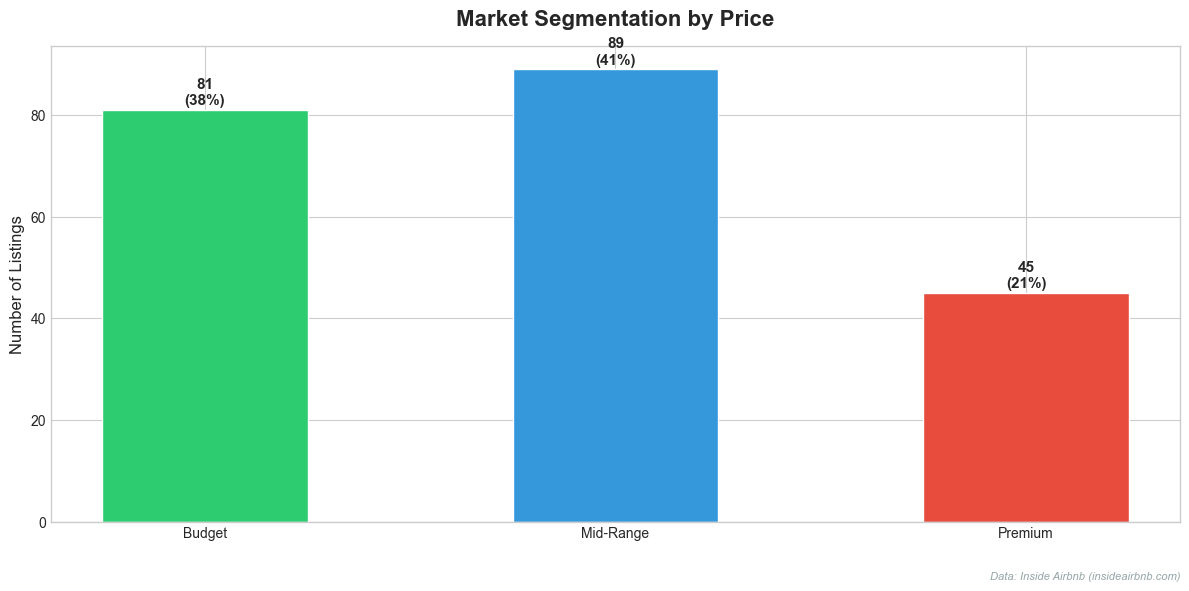

In [3]:
segments = analyzer.segment_by_price()
display(segments.style.format({
    'avg_price': '${:,.0f}', 'median_price': '${:,.0f}',
    'avg_rating': '{:.2f}', 'pct': '{:.1f}%'
}))

listings_seg = analyzer.add_segments_to_df()
charts.plot_segment_distribution(listings_seg, save_as='segment_distribution')
plt.show()

## Price vs. Review Rating

Is there a correlation between price and guest satisfaction? Do expensive listings deliver better experiences?

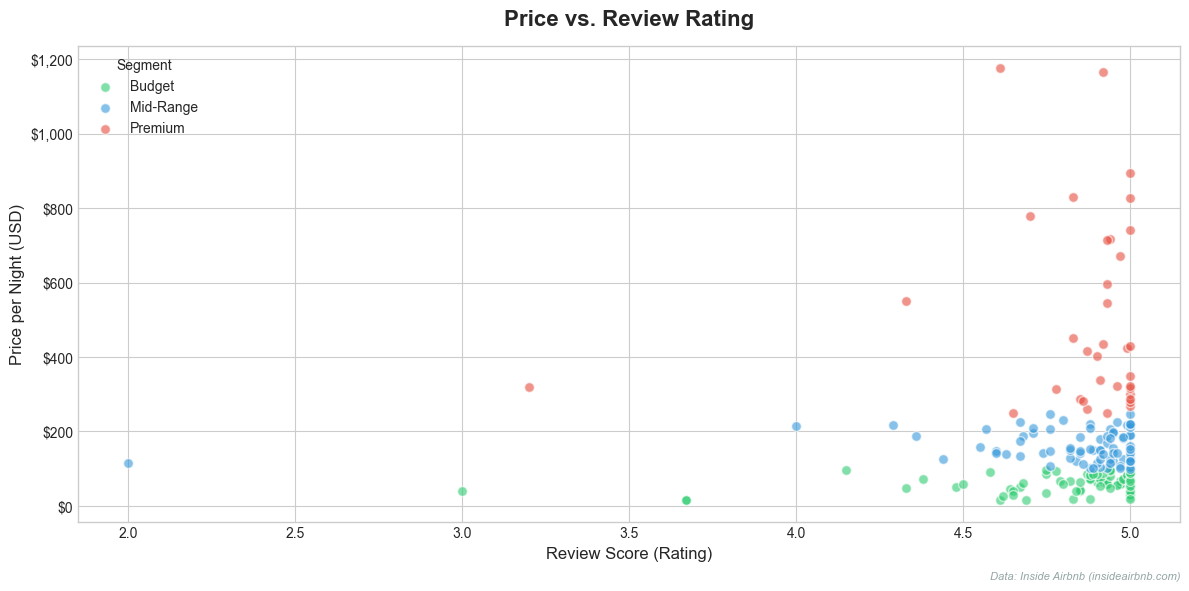

Price-Rating Correlation: 0.065
→ Weak correlation suggests quality is achievable at any price point.


In [4]:
charts.plot_price_vs_rating(listings_seg, save_as='price_vs_rating')
plt.show()

# Correlation
corr_data = listings[['price', 'review_scores_rating']].dropna()
corr = corr_data['price'].corr(corr_data['review_scores_rating'])
print(f'Price-Rating Correlation: {corr:.3f}')
print('→ Weak correlation suggests quality is achievable at any price point.')

## Amenity Analysis

Which amenities are most common, and which ones differentiate premium listings?

Total unique amenities: 444

Top 15 most common:


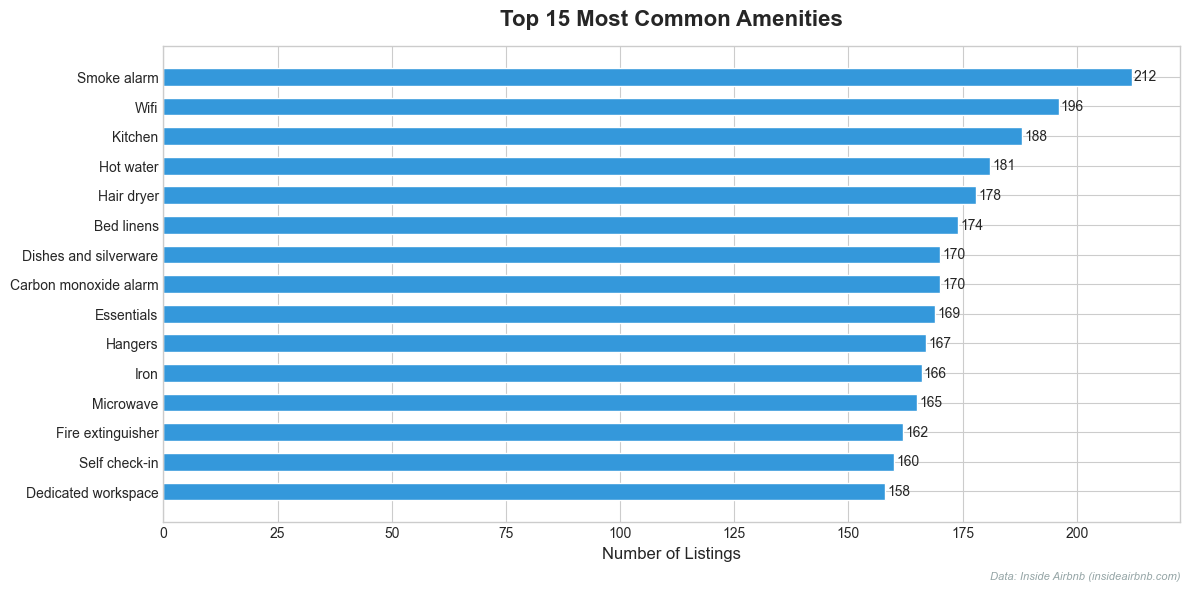

In [5]:
amenity_data = analyzer.get_amenity_analysis()

print(f"Total unique amenities: {amenity_data['total_unique']}")
print(f"\nTop 15 most common:")

charts.plot_amenity_frequency(amenity_data['overall'], top_n=15, save_as='amenity_frequency')
plt.show()

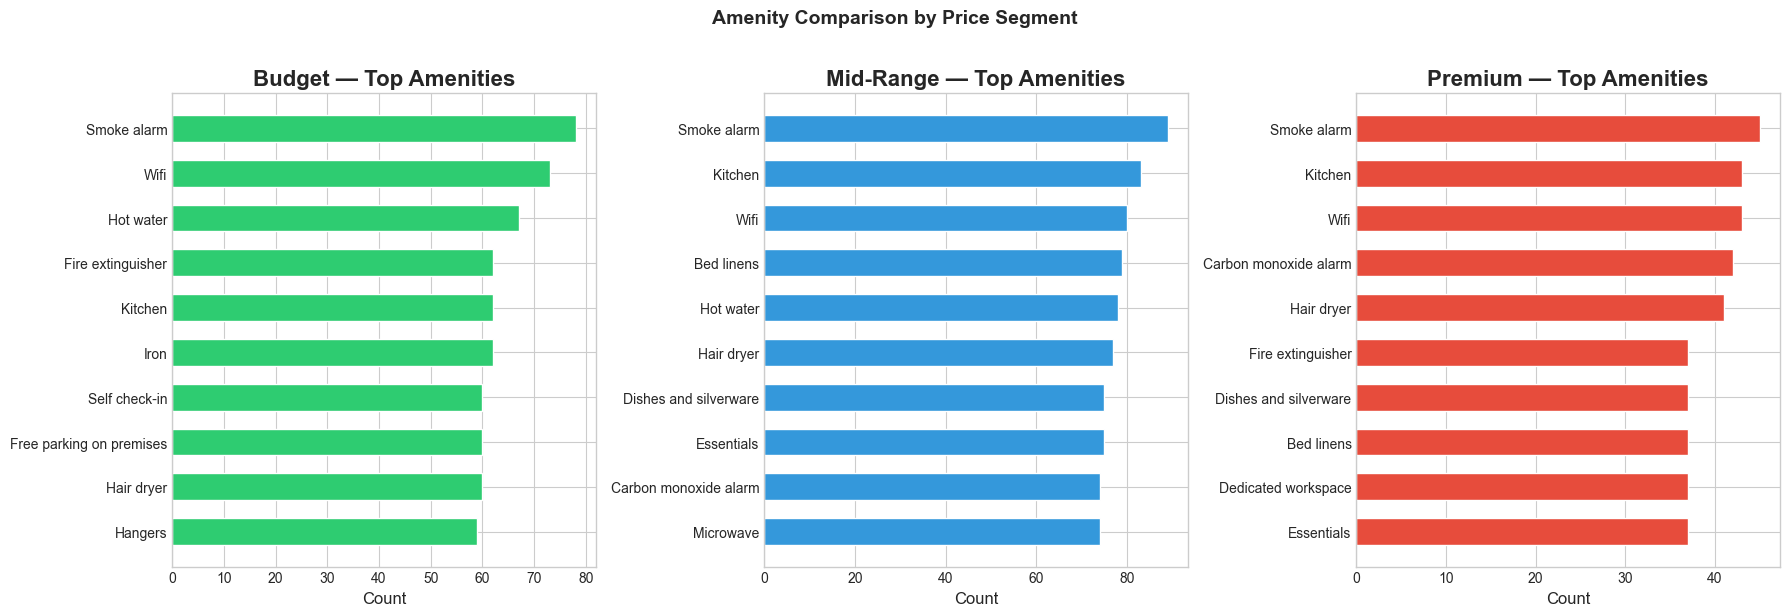

In [6]:
# Compare amenities across segments
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
segment_colors = {'Budget': '#2ecc71', 'Mid-Range': '#3498db', 'Premium': '#e74c3c'}

for ax, (seg_name, seg_amenities) in zip(axes, amenity_data['by_segment'].items()):
    top10 = seg_amenities.head(10).sort_values()
    ax.barh(top10.index, top10.values, color=segment_colors.get(seg_name, '#bdc3c7'),
            edgecolor='white', height=0.6)
    ax.set_title(f'{seg_name} — Top Amenities', fontweight='bold')
    ax.set_xlabel('Count')

plt.suptitle('Amenity Comparison by Price Segment', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Superhost Premium

Do superhosts command higher prices? Do they receive better reviews?

══════════════════════════════════════════════════
    SUPERHOST vs REGULAR HOST
══════════════════════════════════════════════════
  Superhosts:        122 listings
  Regular hosts:     84 listings
  Superhost avg ADR: $193
  Regular avg ADR:   $202
  Price difference:  -4.5%
  Superhost rating:  4.91
  Regular rating:    4.62
══════════════════════════════════════════════════


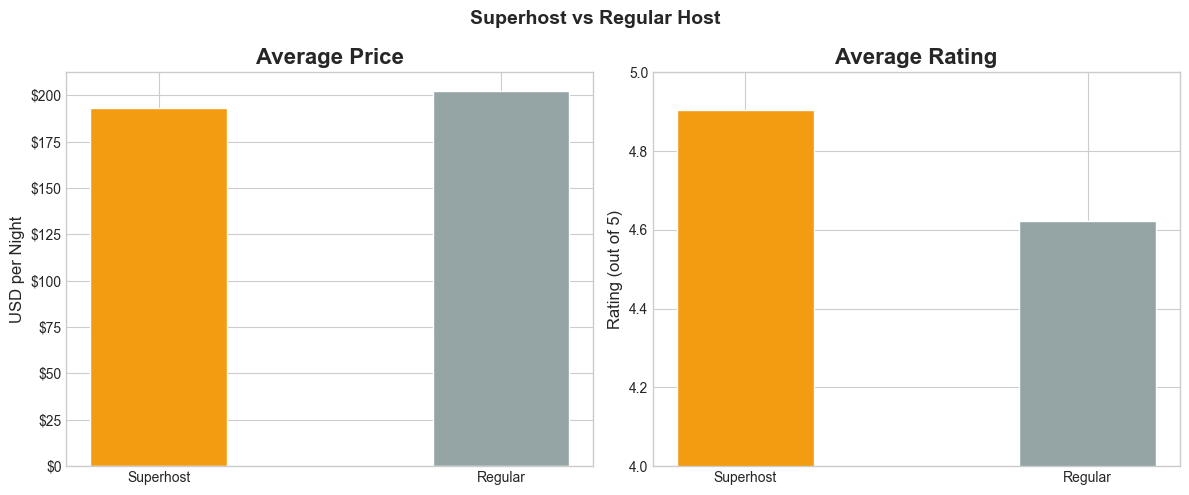

In [7]:
sh_premium = analyzer.get_superhost_premium()

if sh_premium and 'price_premium_pct' in sh_premium:
    print('═' * 50)
    print('    SUPERHOST vs REGULAR HOST')
    print('═' * 50)
    print(f"  Superhosts:        {sh_premium['superhost_count']} listings")
    print(f"  Regular hosts:     {sh_premium['regular_count']} listings")
    print(f"  Superhost avg ADR: ${sh_premium['superhost_avg_price']:,.0f}")
    print(f"  Regular avg ADR:   ${sh_premium['regular_avg_price']:,.0f}")
    print(f"  Price difference:  {sh_premium['price_premium_pct']:+.1f}%")
    print(f"  Superhost rating:  {sh_premium['superhost_avg_rating']:.2f}")
    print(f"  Regular rating:    {sh_premium['regular_avg_rating']:.2f}")
    print('═' * 50)

    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    labels = ['Superhost', 'Regular']

    # Price comparison
    prices = [sh_premium['superhost_avg_price'], sh_premium['regular_avg_price']]
    axes[0].bar(labels, prices, color=['#f39c12', '#95a5a6'], edgecolor='white', width=0.4)
    axes[0].set_title('Average Price', fontweight='bold')
    axes[0].set_ylabel('USD per Night')
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

    # Rating comparison
    ratings = [sh_premium['superhost_avg_rating'], sh_premium['regular_avg_rating']]
    axes[1].bar(labels, ratings, color=['#f39c12', '#95a5a6'], edgecolor='white', width=0.4)
    axes[1].set_title('Average Rating', fontweight='bold')
    axes[1].set_ylabel('Rating (out of 5)')
    axes[1].set_ylim(4.0, 5.0)

    plt.suptitle('Superhost vs Regular Host', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print('Insufficient data for superhost comparison.')

## Market Gaps

Identifying underserved segments — combinations of neighborhood and price tier with low supply.

In [8]:
gaps = analyzer.identify_market_gaps()

if gaps:
    gaps_df = pd.DataFrame(gaps)
    display(gaps_df.head(10).style.format({'pct_of_neighborhood': '{:.1f}%'}))
else:
    print('No significant market gaps identified in the sample data.')

,neighbourhood,segment,current_listings,pct_of_neighborhood,opportunity
0,78751,Mid-Range,0,0.0%,Low mid-range supply in 78751
1,78723,Premium,0,0.0%,Low premium supply in 78723
2,78756,Premium,0,0.0%,Low premium supply in 78756
3,78701,Budget,1,5.6%,Low budget supply in 78701
4,78751,Premium,1,6.2%,Low premium supply in 78751
5,78741,Premium,1,8.3%,Low premium supply in 78741
6,78744,Premium,1,10.0%,Low premium supply in 78744
7,78745,Premium,2,15.4%,Low premium supply in 78745
8,78744,Mid-Range,2,20.0%,Low mid-range supply in 78744
9,78703,Budget,2,22.2%,Low budget supply in 78703


## Key Findings

1. **Mid-range dominates** — the $100–$250 segment has the most listings, indicating strong competition in this tier
2. **Price and rating are weakly correlated** — high ratings are achievable at any price point, meaning quality of experience matters more than luxury
3. **Essential amenities** are nearly universal (WiFi, kitchen, A/C) — the differentiators are extras like pools, hot tubs, and dedicated workspaces
4. **Superhosts earn a rating premium** — consistently higher guest satisfaction scores, though the price premium varies
5. **Market gaps exist** in specific neighborhood-segment combinations — particularly budget options in premium neighborhoods and premium offerings in emerging areas

**Recommendations:**
- New listings should target underserved segments identified in the gap analysis
- Investing in superhost status pays off through higher visibility and guest trust
- Amenity strategy should focus on differentiators, not basics
- Mid-range pricing requires strong differentiation to stand out in a crowded segment